In [1]:
import pandas as pd
import os
import json
import numpy as np
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat
import matplotsoccer as mps


In [16]:
# Load the xT model in
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT_model = xthreat.load_model(url_grid)

### Get event data from the data directory 

In [3]:
def create_statsbomb_dataset():
    """
    Returns a concatenated dataset of all files and match details.
    Assumes the data is in a folder named man-city-data in the root directory
    """
    dfs = []

    full_data_path = '../man-city-data/StatsBomb/Data'
    for dir in os.listdir(full_data_path):
        if 'events' in dir:
            dfs.append(pd.read_json(f'{full_data_path}/{dir}'))
        
    match_details = pd.read_json(f'{full_data_path}/FAWSL_22_23.json')
    return dfs, match_details

In [4]:
def normalize_dataframe(df):
    json_data = json.loads(df.to_json(orient='records'))
    norm_df = pd.json_normalize(json_data)
    return norm_df

In [5]:
def rename_cols(df):
    new_cols = [i.replace('.', '_') for i in df.columns]
    df.columns = new_cols
    df = df.rename(columns={
        'period': 'period_id',
        'id':'event_id',
    })
    return df

In [6]:
dfs, match_details = create_statsbomb_dataset()
full_df = pd.concat(dfs)

In [7]:
event_data = rename_cols(normalize_dataframe(full_df))
match_details = rename_cols(normalize_dataframe(match_details))
match_details

,match_id,match_date,kick_off,home_score,away_score,attendance,behind_closed_doors,neutral_ground,play_status,match_status,...,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name,referee
0,3856041,2023-03-05,14:30:00.000,5.0,1.0,None,False,False,Normal,available,...,Regular Season,4979,Leigh Sports Village Stadium,68,England,1004975.0,Melissa Burgin,68.0,England,NaN
1,3856039,2023-03-05,15:00:00.000,0.0,2.0,None,False,False,Normal,available,...,Regular Season,4989,Walton Hall Park,68,England,898.0,Amy Fearn,68.0,England,NaN
2,3852829,2023-02-12,14:00:00.000,1.0,2.0,None,False,False,Normal,available,...,Regular Season,600,Tottenham Hotspur Stadium,68,England,898.0,Amy Fearn,68.0,England,NaN
3,3856035,2023-02-05,14:00:00.000,0.0,0.0,None,False,False,Normal,available,...,Regular Season,4979,Leigh Sports Village Stadium,68,England,1711.0,Emily Heaslip,68.0,England,NaN
4,3856037,2023-02-05,20:45:00.000,0.0,0.0,None,False,False,Normal,available,...,Regular Season,116891,Chigwell Construction Stadium,68,England,2127.0,Richie Watkins,68.0,England,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,3852835,2022-09-16,20:30:00.000,4.0,0.0,None,False,False,Normal,available,...,Regular Season,456,Meadow Park,68,England,928.0,Lisa Benn,68.0,England,NaN
128,3852833,2023-02-12,16:00:00.000,2.0,6.0,None,False,False,Normal,available,...,Regular Season,1001076,Broadfield Stadium,68,England,926.0,Elizabeth Simms,68.0,England,NaN
129,3852832,2023-02-11,14:30:00.000,2.0,1.0,None,False,False,Normal,available,...,Regular Season,99,Academy Stadium,68,England,566.0,Rebecca Welch,68.0,England,NaN
130,3852831,2022-11-24,21:00:00.000,3.0,3.0,None,False,False,Normal,available,...,Regular Season,223,Select Car Leasing Stadium,68,England,898.0,Amy Fearn,68.0,England,NaN


In [18]:
match_details.columns

Index(['match_id', 'match_date', 'kick_off', 'home_score', 'away_score',
       'attendance', 'behind_closed_doors', 'neutral_ground', 'play_status',
       'match_status', 'match_status_360', 'last_updated', 'last_updated_360',
       'match_week', 'competition_competition_id', 'competition_country_name',
       'competition_competition_name', 'season_season_id',
       'season_season_name', 'home_team_home_team_id',
       'home_team_home_team_name', 'home_team_home_team_gender',
       'home_team_home_team_youth', 'home_team_home_team_group',
       'home_team_country_id', 'home_team_country_name', 'home_team_managers',
       'away_team_away_team_id', 'away_team_away_team_name',
       'away_team_away_team_gender', 'away_team_away_team_youth',
       'away_team_away_team_group', 'away_team_country_id',
       'away_team_country_name', 'away_team_managers', 'metadata_data_version',
       'metadata_shot_fidelity_version', 'metadata_xy_fidelity_version',
       'competition_stage_id'

Create the columns that are needed by SPADL that are missing from the data source

In [8]:
event_data['freeze_frame_360'] = [[] for _ in range(len(event_data))]
event_data['visible_area_360'] = [[] for _ in range(len(event_data))]
event_data['extra'] = [json.loads('{}') for _ in range(len(event_data))] 
event_data['game_id'] = [3852832 for _ in range(len(event_data))] 

In [14]:
print(event_data.columns)

Index(['event_id', 'index', 'period_id', 'timestamp', 'minute', 'second',
       'possession', 'obv_for_after', 'obv_for_before', 'obv_for_net',
       ...
       'clearance_other', 'block_save_block', 'shot_deflected',
       'foul_committed_offensive', 'foul_committed_penalty',
       'foul_won_penalty', 'freeze_frame_360', 'visible_area_360', 'extra',
       'game_id'],
      dtype='object', length=165)


In [29]:
data = pd.read_json("../man-city-data/StatsBomb/Data/ManCity_Arsenal_events.json")
data = rename_cols(normalize_dataframe(data))
data

,event_id,index,period_id,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution_replacement_name,pass_inswinging,foul_committed_card_id,foul_committed_card_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_miscommunication,pass_cut_back,dribble_overrun,pass_outswinging
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,1681344000000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15347fb5-bd07-47c7-9331-b5d0d6901847,2,1,1681344000000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,1681344000000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b3f6b437-6189-49a7-84b3-06992c851d5d,4,1,1681344000000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,1681344000280,0,0,2,0.015265,0.007439,0.007826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,444d8040-a64f-4d7b-a1ef-11fefd77fe15,3625,2,1681346990497,94,50,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3625,e284d714-7d5f-421b-b75d-18dc784a6bcd,3626,2,1681346990497,94,50,192,0.007870,0.005570,0.002300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3626,5eee8f04-dd7a-4d58-9354-7ac8bd05625b,3627,2,1681346990617,94,50,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3627,eef577be-b34f-4e69-a0cd-311e7983cb6b,3628,2,1681346994982,94,54,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data['freeze_frame_360'] = [[] for _ in range(len(data))]
data['visible_area_360'] = [[] for _ in range(len(data))]
data['extra'] = [json.loads('{}') for _ in range(len(data))] 
data['game_id'] = [3852832 for _ in range(len(data))] 
data = rename_cols(data)

In [34]:
data.to_csv("statsbmb.csv")

In [35]:
data.columns

Index(['event_id', 'index', 'period_id', 'timestamp', 'minute', 'second',
       'possession', 'obv_for_after', 'obv_for_before', 'obv_for_net',
       ...
       'bad_behaviour_card_id', 'bad_behaviour_card_name',
       'pass_miscommunication', 'pass_cut_back', 'dribble_overrun',
       'pass_outswinging', 'freeze_frame_360', 'visible_area_360', 'extra',
       'game_id'],
      dtype='object', length=151)

In [84]:
df_grouped = data.groupby(['possession', 'team_name']).agg({'obv_total_net': ['sum', 'mean']}).reset_index()
df_grouped.dropna(inplace=True)
df_grouped.columns = ['possession', 'team_name', 'obv_total_net_sum', 'obv_total_net_mean']

df_grouped

,possession,team_name,obv_total_net_sum,obv_total_net_mean
3,2,Manchester City WFC,-0.017424,-0.000830
4,3,Arsenal WFC,0.005628,0.000563
5,3,Manchester City WFC,0.005018,0.001004
6,4,Arsenal WFC,-0.000691,-0.000346
8,5,Arsenal WFC,-0.015100,-0.005033
...,...,...,...,...
353,190,Manchester City WFC,0.000305,0.000102
354,191,Arsenal WFC,-0.002077,-0.002077
355,191,Manchester City WFC,0.002077,0.002077
356,192,Arsenal WFC,0.006854,0.003427


<Axes: xlabel='team_name', ylabel='obv_total_net_sum'>

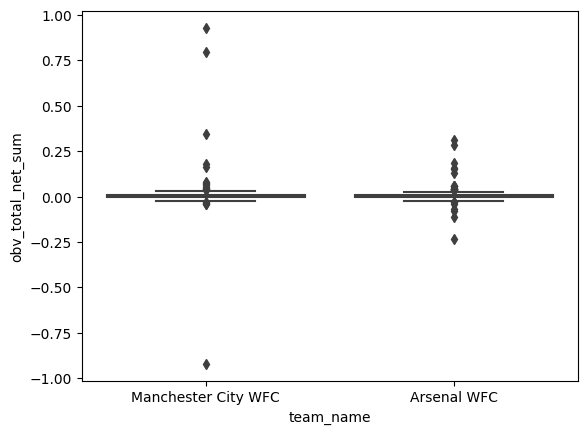

In [86]:
import seaborn as sns
# assuming your DataFrame is named "df_grouped"
sns.boxplot(x="team_name", y="obv_total_net_sum", data=df_grouped)

In [87]:
df_possession_first = data.drop_duplicates(subset=['possession'], keep='first')
df_merged = pd.merge(df_grouped, df_possession_first[['possession', 'minute']], on='possession')
df_merged = df_merged.rename(columns={'minute': 'possession minute'})
df_merged = pd.merge(df_merged, df_possession_first[['possession', 'second']], on='possession')
df_merged = df_merged.rename(columns={'second': 'possession second'})

df_possession_last = data.drop_duplicates(subset=['possession'], keep='last')
df_merged = pd.merge(df_merged, df_possession_last[['possession', 'minute']], on='possession')
df_merged = df_merged.rename(columns={'minute': 'possession end minute'})
df_merged = pd.merge(df_merged, df_possession_last[['possession', 'second']], on='possession')
df_merged = df_merged.rename(columns={'second': 'possession end second'})
df_merged

,possession,team_name,obv_total_net_sum,obv_total_net_mean,possession minute,possession second,possession end minute,possession end second
0,2,Manchester City WFC,-0.017424,-0.000830,0,0,0,31
1,3,Arsenal WFC,0.005628,0.000563,0,31,1,9
2,3,Manchester City WFC,0.005018,0.001004,0,31,1,9
3,4,Arsenal WFC,-0.000691,-0.000346,1,13,1,14
4,5,Arsenal WFC,-0.015100,-0.005033,1,15,1,31
...,...,...,...,...,...,...,...,...
289,190,Manchester City WFC,0.000305,0.000102,94,17,94,20
290,191,Arsenal WFC,-0.002077,-0.002077,94,36,94,37
291,191,Manchester City WFC,0.002077,0.002077,94,36,94,37
292,192,Arsenal WFC,0.006854,0.003427,94,48,94,54


In [83]:
df_merged.to_csv("obv_possessions.csv")

In [82]:
spadl_df = spadl.statsbomb.convert_to_actions(data, 746)
spadl_df

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,3852832,edbc9819-3d24-4c37-adc0-06949261903b,1,0.0,746,25554.0,52.058824,34.430380,52.058824,34.430380,0,1,0,0
1,3852832,NaN,1,0.5,746,25632.0,52.058824,34.430380,38.294118,37.615190,21,1,0,1
2,3852832,ce398ea2-769b-43d0-8911-a71d6ad7ce82,1,1.0,746,25632.0,38.294118,37.615190,38.294118,37.615190,21,1,0,2
3,3852832,9fdba1c7-4244-43fd-b0fc-b6f944407c1f,1,2.0,746,25632.0,39.529412,37.787342,39.529412,37.787342,0,1,0,3
4,3852832,NaN,1,2.5,746,10185.0,39.529412,37.787342,26.911765,20.830380,21,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,3852832,8593ff64-3c81-4554-a4a3-0c0db0dbcfaf,2,2988.0,746,221888.0,92.029412,0.000000,92.029412,0.000000,0,1,0,3066
3067,3852832,50a135b5-6199-411e-a77a-9f1364120ed6,2,2989.0,968,5000.0,101.205882,5.164557,101.205882,5.164557,0,1,0,3067
3068,3852832,e284d714-7d5f-421b-b75d-18dc784a6bcd,2,2990.0,968,15620.0,102.352941,4.734177,102.352941,4.734177,21,1,0,3068
3069,3852832,NaN,2,2990.0,968,15620.0,102.352941,4.734177,95.382353,12.050633,21,1,0,3069


### Give actions a value using xT model

In [15]:
spadl_df = spadl.statsbomb.convert_to_actions(event_data, 746)
spadl_df.to_csv("spadl.csv")

In [21]:
df_actions_ltr = spadl.play_left_to_right(spadl_df, 746)
spadl_df["xT_value"] = xT_model.rate(df_actions_ltr)

In [22]:
spadl_df.xT_value.describe()

count    14570.000000
mean         0.000024
std          0.014777
min         -0.245306
25%          0.000000
50%          0.000000
75%          0.000000
max          0.244970
Name: xT_value, dtype: float64

In [23]:
# columns = ['counterpress', 
#            'duration',
#            'event_id',
#            'extra',
#            'freeze_frame_360',
#            'game_id',
#            'index',
#            'location',
#            'minute',
#            'period_id',
#            'play_pattern_id',
#            'play_pattern_name',
#            'player_id',
#            'player_name',
#            'position_id',
#            'position_name',
#            'possession',
#            'possession_team_id',
#            'possession_team_name',
#            'related_events',
#            'second',
#             'team_id',
#             'team_name',
#             'timestamp',
#             'type_id',
#             'type_name',
#             'under_pressure',
#             'visible_area_360'
#            ]